# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Vikesh | Patel | Vikesh Patel 2024-11-01| 4 | 25% |
| Member 2: | Socretes | Saha | Socretes Saha 2024-11-05 | 4 | 25% |
| Member 3: | Ray | Pan | Ray Pan 2024-11-06| 4 | 25% |
| Member 4: | Chunsheng | Xiao | Chunsheng Xiao 2024-11-07 | 4 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

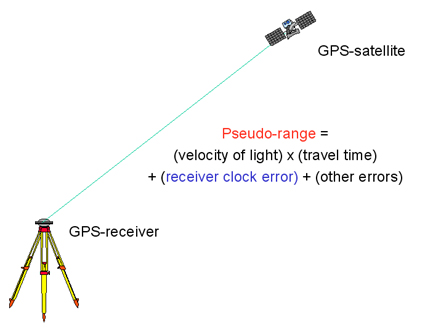

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [22]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

print("pseudorange:", pseudorange)
print("sat_pos:", sat_pos)
print(n)

pseudorange: [22919740.9614295 20459894.0877988 22400338.4134134 22829140.9126004
 22342014.8171753 25646454.5362932 23814776.2454228 24311399.3171521
 21353640.1406793 24971609.6374347 20638981.0590005]
sat_pos: [[  5280791.73836563 -25501460.1192133    4649508.28809917]
 [ -2159656.05205653 -21116024.7920163   15597909.1971221 ]
 [ 10371852.1682927  -21713111.3497771   10558686.998121  ]
 [-16085760.7811889    4285071.21612309  20742042.1246963 ]
 [-14312988.0806279  -22045014.2659254    4671208.3988653 ]
 [ -2435718.18737303  16257205.12951     21099779.5379103 ]
 [ 15912467.1868696   -3462515.31492602  21053628.253335  ]
 [ 16271848.163885     -218766.32031082  21035332.7037679 ]
 [-19247035.5286677   -7259803.67892242  16472981.9071979 ]
 [-15931152.0364578   12077367.2515846   18058076.7648504 ]
 [ -7680014.10843999 -13855462.7231353   21842975.3728112 ]]
11


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    # changing the shape so that satellite pos array and reciever pos array become same size
    receiver_pos = np.reshape(receiver_pos, (1, -1))
    if satellite_pos.ndim == 1:  # If satellite_pos is 1D, make it 2D
        satellite_pos = np.reshape(satellite_pos, (1, -1))
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [23]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    L = 0
    for i in range(len(s_pos)):
        predicted_pseudorange = euclidean_norm(r_pos, s_pos[i])[0] + cdT  # Calculate predicted pseudorange
        residual = pseudorange[i] - predicted_pseudorange  # Calculate residual (real pseudorange - predicted pseudorange)
        L += residual ** 2
    return L

In [24]:
print(cost_function(GroundTruth, 0, sat_pos, pseudorange))

218.11293249462665


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [25]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    grad = np.zeros(4)  # Initialize the gradient array with zeros
    for i in range(len(s_pos)):
        predicted_pseudorange = euclidean_norm(r_pos, s_pos[i])[0] + cdT  # Calculate predicted pseudorange (geometric range + cdT)
        residual = pseudorange[i] - predicted_pseudorange  # Calculate residual (real pseudorange - predicted pseudorange)
        distance = euclidean_norm(r_pos, s_pos[i])[0]  # Calculate geometric distance

        if distance != 0:
            grad[:3] += -2 * residual * (r_pos - s_pos[i]) / distance #if distance is not 0, calculate x, y, and z's gradient
        grad[3] += -2 * residual  # Calculate cdT's gradient
    return grad

In [26]:
print(gradient(GroundTruth, 0, sat_pos, pseudorange))

[ 12.33149924 -10.78111633  41.1025859  -87.79500721]


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [78]:
# Gradient descent algorithm for non-linear least squares estimation
# Adjusted learning rate and iteration count to address "overflow" and "nan" issues caused by high learning rate, which led to numerical instability and convergence failure.


def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    #initalize
    global steps_count
    global arr_cost
    global arr_grad
    global arr_err
    steps_count = 0
    arr_cost = []
    arr_grad = []
    arr_err = []


    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3] #Seperate reciever's position
        cdT = X[3] #Seperate cdT

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

        #increase step count
        steps_count+=1

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [87]:
optimized_params = gradient_descent(pseudorange, sat_pos, learning_rate=0.0005, max_iters=200000, tolerance=1e-6)

# Calculate final position errors of receiver by comparing with ground truth
final_position_error = optimized_params[:3] - GroundTruth

# Calculate final cost value using the cost function
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

# Calculate final gradient values using the gradient function
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)


# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162952e+06  4.95248538e+06  6.44140645e+00]
Final Position Errors of Receiver: [-3.06168702 -2.34230964  3.759171  ]
Number of Steps Taken for Convergence: 53291
Final Cost Value: 6.198477211269786
Final Gradient Values: [ 0.00220038  0.01226044 -0.03768146 -0.02136264]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

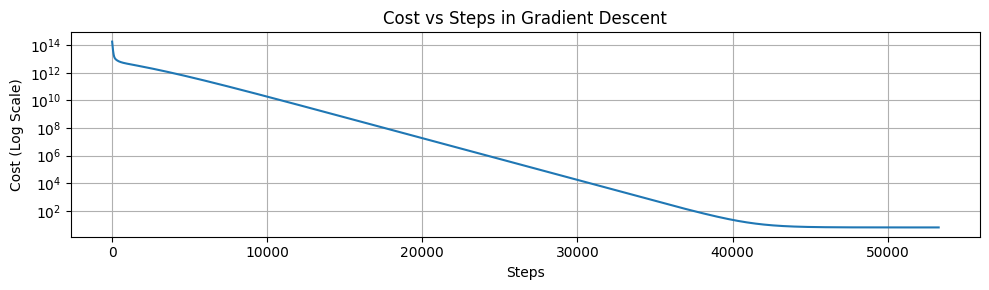

The cost decreases rapidly in the initial steps and gradually flattens out as it approaches a minimum value, indicating convergence around step 42,000.


In [92]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot cost vs steps with logarithmic scaling on the y-axis
ax.semilogy(range(len(arr_cost)), arr_cost, label="Cost")

# Label the axes
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (Log Scale)")

# Set title
ax.set_title("Cost vs Steps in Gradient Descent")

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The cost decreases rapidly in the initial steps and gradually flattens out as it approaches a minimum value, indicating convergence around step 42,000.")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

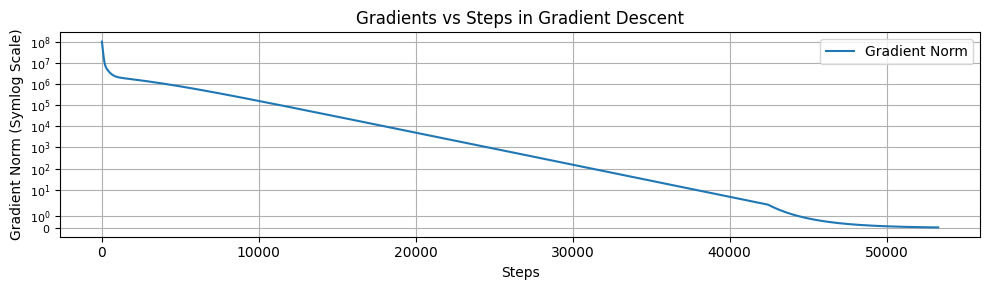

The gradient norm shows a sharp initial drop, then steadily decreases, with minimal fluctuations near zero, signaling effective convergence by step 50,000.


In [93]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
gradient_norms = [np.linalg.norm(grad) for grad in arr_grad]
# Use symlog scaling on the y-axis to handle positive and negative gradients symmetrically
ax.plot(gradient_norms, label="Gradient Norm")
ax.set_yscale('symlog')

# Label each axis
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Norm (Symlog Scale)")

# Set title and legend
ax.set_title("Gradients vs Steps in Gradient Descent")
ax.legend()

# Set y-axis tick label size
ax.tick_params(axis='y', labelsize=8)

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The gradient norm shows a sharp initial drop, then steadily decreases, with minimal fluctuations near zero, signaling effective convergence by step 50,000.")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

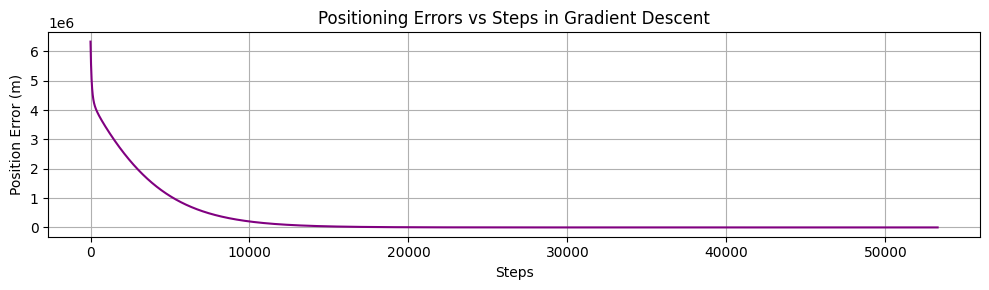

The positioning error decreases rapidly at first and stabilizes close to zero around step 12,000.


In [94]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
position_errors = [np.linalg.norm(error) for error in arr_err]
# Plot position errors over steps
ax.plot(position_errors, label="Position Error Norm", color="purple")

# Label each axis
ax.set_xlabel("Steps")
ax.set_ylabel("Position Error (m)")
ax.set_title("Positioning Errors vs Steps in Gradient Descent")

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The positioning error decreases rapidly at first and stabilizes close to zero around step 12,000.")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [84]:
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6)

# Calculate final position errors of receiver by comparing with ground truth
final_position_error_2 = optimized_params_2[:3] - GroundTruth

# Calculate final cost value using the cost function
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)

# Calculate final gradient values using the gradient function
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)


# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors of Receiver:", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.1970934384156395
Final Gradient Values: [ 0.00048759  0.0027168  -0.00834987 -0.00473382]


In [85]:
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=30000, tolerance=1e-6)

# Calculate final position errors of receiver by comparing with ground truth
final_position_error_3 = optimized_params_3[:3] - GroundTruth

# Calculate final cost value using the cost function
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)

# Calculate final gradient values using the gradient function
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)


# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_3)
print("Final Position Errors of Receiver:", final_position_error_3)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_3)
print("Final Gradient Values:", final_gradient_3)

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45048680e+00]
Final Position Errors of Receiver: [-3.0626223  -2.34752101  3.77518774]
Number of Steps Taken for Convergence: 27145
Final Cost Value: 6.197741842276456
Final Gradient Values: [ 0.0015476   0.00862312 -0.02650245 -0.01502497]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

Q1. With a higher learning rate (0.01), the algorithm converged much faster (in 2871 steps) with a lower final cost value compared to lower learning rates (0.0005 and 0.001), which required more iterations to converge and resulted in slightly higher final costs. This shows that an appropriate learning rate (0.01 in this case) accelerates convergence and improves optimization results, while too low a learning rate slows convergence without significant improvements in accuracy.

Q2. LSE aims to minimize the sum of squared errors and often provides an analytical solution for simple problems, while Gradient Descent is an iterative optimization algorithm that adjusts parameters step-by-step based on gradients. In this complex, nonlinear case, Gradient Descent enabled us to approximate the minimum by iteratively reducing errors, as an analytical LSE solution was not feasible. Gradient Descent requires careful tuning of hyperparameters (like learning rate) to achieve efficient and accurate convergence.



# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [96]:
!pip install ucimlrepo

In [97]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
x = phishing_websites.data.features
y = phishing_websites.data.targets


# TO DO: display sizes of X and y (1 mark)
# Display sizes of X and y
print("Size of x (features):", x.shape)
print("Size of y (labels):", y.shape)


Size of x (features): (11055, 30)
Size of y (labels): (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

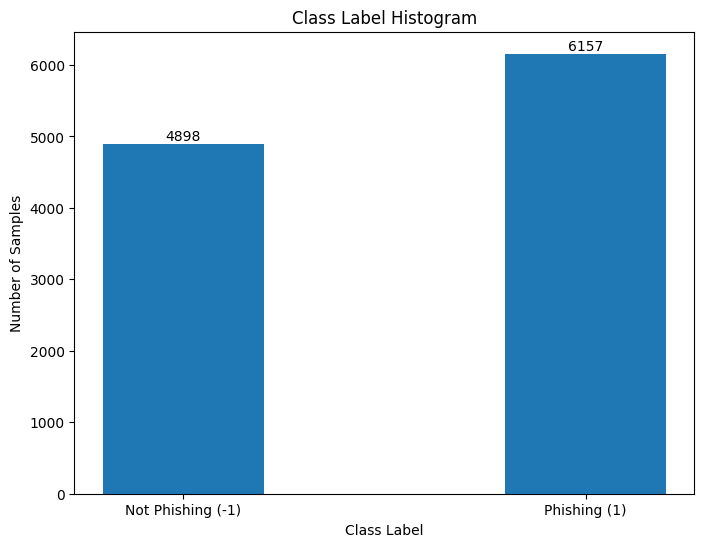

In [98]:
# TO DO: Check the class distribution of y (2 mark)
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), tick_label=["Not Phishing (-1)", "Phishing (1)"])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')



# Display exact values for each bin in the histogram
plt.title("Class Label Histogram")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [99]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
x_small, _, y_small, _ = train_test_split(x, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (features):", x_small.shape)
print("Size of y_small (labels):", y_small.shape)

Size of X_small (features): (331, 30)
Size of y_small (labels): (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [100]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
#===============================================================================
###STEPS 3 and 4
from sklearn.linear_model import LogisticRegression #3-1
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

def test_model(x_train, x_test, y_train, y_test):
  #training model
  y_train = y_train.values.ravel()
  y_test = y_test.values.ravel()
  model=LogisticRegression(max_iter=2000) #3-2
  model.fit(x_train, y_train) #3-3

  #4-1 data size
  data_size = x_train.shape[0] + x_test.shape[0]

  #4-2 number of training samples
  training_samples = x_train.shape[0]

  #4-3 number of testing samples
  testing_samples = x_test.shape[0]

  #4-4 training accuracy
  training_accuracy = accuracy_score(y_train, model.predict(x_train))

  #4-5 testing accuracy
  testing_accuracy = accuracy_score(y_test, model.predict(x_test))

  #4-6 log loss
  y_pred_proba = model.predict_proba(x_test)
  log_loss_value = log_loss(y_test, y_pred_proba)

  #return as dic
  return {
      'Data Size': data_size,
      'Training Samples': training_samples,
      'Testing Samples': testing_samples,
      'Training Accuracy': training_accuracy,
      'Testing Accuracy': testing_accuracy,
      'Log Loss': log_loss_value
  }


#  Calculations for all 3 different tests and append to results
results = []

#  1. Full dataset (x and y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
results.append(test_model(x_train, x_test, y_train, y_test))

#  2. First Two Columns (Only first two columns of x and y)
x_train, x_test, y_train, y_test = train_test_split(x.iloc[:, :2], y, test_size=0.3, random_state=0)
results.append(test_model(x_train, x_test, y_train, y_test))

#  3. Small Dataset (x_small and y_small)
x_train, x_test, y_train, y_test = train_test_split(x_small, y_small, test_size=0.3, random_state=0)
results.append(test_model(x_train, x_test, y_train, y_test))

#===============================================================================
###STEP 5
results_df = pd.DataFrame(results, index=["Full Dataset", "First Two Columns", "Small Dataset"])
print(results_df)


                   Data Size  Training Samples  Testing Samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Small Dataset            331               231              100   

                   Training Accuracy  Testing Accuracy  Log Loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Small Dataset               0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [102]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

#Target vector and predicted values
target_vector = y.values.ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
model = LogisticRegression(max_iter=2000)
model.fit(x_train, y_train.values.ravel())
predict_values = model.predict(x_test)

print("Dimension of predicted output:", predict_values.shape) #dimension


Dimension of predicted output: (3317,)



Confusion Matrix:
[[1341  157]
 [  99 1720]]


Text(113.9222222222222, 0.5, 'true value')

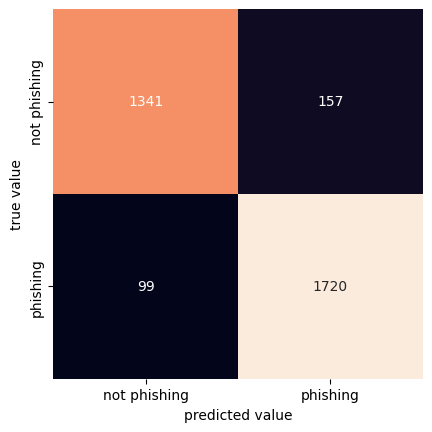

In [103]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, predict_values)
print("\nConfusion Matrix:")
print(conf_mat)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [104]:
# TO DO: Print classification report (2 marks)
print("\nClassification Report:\n\n")
print(classification_report(y_test, predict_values))



Classification Report:


              precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---
1. From the class label histogram, the phishing (value = 1) and non-phishing (value = -1) samples are relatively close in count, with 6157 and 4898 samples, respectively. Although there is a slight imbalance, it is not considered as severely imbalanced.

2. It can be judged by the accuracy of the training set and test set. If the accuracy of the training set and the test set differ too much, we can consider there's a over-fitting. If both of the accuracy are small, we can consider there's a under-fitting. Based on that, there is no over-fitting or under-fitting in our full dataset, but under-fitting in first-two columns and there might be over-fitting in small dataset.

3. Training and testing accuracy tend to be similar and generally higher with more data. In this case, while training accuracy is 93.23% and testing accuracy is 92.28% with the full dataset, indicating that the model performed well when enough data was available, with the small dataset, training accuracy is higher than testing accuracy (94.37% vs. 91.00%), which could indicate overfitting.

4. **False Positive** means the model incorrectly classifies a "non-phishing website" as a "phishing website"; on the other hand, **False Positive** means the model incorrectly classifies a "phishing website" as "non-phishing".Accordingly, a false negative is worse because it is more dangerous for the users which is more likely to expose them to a phishing attack.

5. In this case, it would be better to maximize recall to ensure that phishing websites are detected as much as possible. To increase recall, we could lower the classification threshold, making the model more likely to classify samples as phishing. We could also adjust the weight parameter in LogisticRegression to give more weight to the phishing class.

6. The interpretation of log loss for each of the 3 cases is as below:

*  **Full Dataset:**
  
    The Log Loss is 0.190326, showing relatively accurate probability predictions due to sufficient data and features, allowing the model to learn well.



  *   **First Two Columns:**
  
    The Log Loss is 0.683573, which suggests that the model struggles to make accurate predictions with only two features, leading to underfitting.



  *  **Small Dataset:**
  
    The Log Loss is 0.200366, falling between the other two cases. Due to the limited data size, the model has weaker generalization capabilities, though the features provide some predictive power.